# Sending a ramp pulse through a 3 cavity-2 qubit system, <mark>with thermal losses</mark> 

1. **Introduction**
2. **Problem parameters**
3. **Setting up operators, Hamiltonian's, and the initial state**
4. **Generating a pulse wave**
    * No thermal losses considered
5. **Results**
    * Final state, Fidelity, Concurrence

<u>Author</u> : Soumya Shreeram (shreeramsoumya@gmail.com)<br>
<u>Supervisor</u> : Yu-Chin Chao (ychao@fnal.gov) <br>
<u>Date</u>$\ \ \ \$: 22nd July 2019<br>

This script was coded as part of the Helen Edwards Summer Internship program at Fermilab.

## 1. Introduction

A multi-mode QED architecture is explored as described in by [McKay et *al*](http://schusterlab.uchicago.edu/static/pdfs/McKay2015.pdf). The hamiltonian for such a system with two qubits with frequencies $v_{Q,1}$, $v_{Q,2}$, and $n$ mode filter can be described as the sum of the qubit Hamiltonian, $\hat{H}_Q$, the filter Hamiltonian, $\hat{H}_F$, and the qubit-filter coupling Hamiltonian, $\hat{H}_{Q-F},$
$$ \hat{H} = \hat{H_Q} + \hat{H_F} + \hat{H}_{Q-F} $$

$$ \hat{H_Q} = h\ v_{Q,1}\ \frac{\hat{ \sigma}^z_1}{2} + h\ v_{Q,2}\ \frac{\hat{ \sigma}^z_2}{2}$$

$$ \hat{H}_{F} = \sum_{i=1}^{n}h\ v_{F}\ \hat{a}^{\dagger}_i \hat{a}_i +  \sum_{i=2}^{n}h\ g_{F}\ (\hat{a}^{\dagger}_i \hat{a}_{i-1} + \hat{a}^{\dagger}_{i-1} \hat{a}_i)$$

$$ \hat{H}_{Q-F} = h\ g_{Q1,F}\ (\hat{a}^{\dagger}_1 \hat{\sigma}^-_1 + \hat{a}_1 \hat{\sigma}^+_1) + h\ g_{Q2,F}\ (\hat{a}^{\dagger}_n \hat{\sigma}^-_2 + \hat{a}_n \hat{\sigma}^+_2)$$

where $\hat{\sigma}^{+(-)}$ is the raising and lowering operator for the qubit, $\hat{a}_i$ creates a photon in the $i^{th}$ resonantor, $g_F$ is the filter-filter coupling, and $g_{Q,F}$ is the qubit-filter coupling.

Here we must also account for the interaction of the quantum state with it's environment. This can be represented by a non-Hermitian term in the Hamiltonian such that,
$$\displaystyle H_{\rm eff}(t) = H(t) - \frac{i\hbar}{2}\sum_n c_n^\dagger c_n$$
where $c_n$ is the collapse operator

The code calculates the occupation probability for a system when a ramp pulse is genrated at the qubit 1 resonance frequency.

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

import numpy as np
from numpy import ones,vstack
from numpy.linalg import lstsq
from math import pi

from time import sleep
import sys

from qutip import *

## 2. Problem parameters
Here we use $\hbar=1$; the coupling terms are redefined with a multiple of $2\pi$ before them for convinience.

In [98]:
"""------------- FREQUENCIES -----------------"""
w_q1 = 2*pi*6.5;     # Qubit 1 frequency
w_q2 = 2*pi*6.8;     # Qubit 2 frequency: range from 1-9 GHz
w_f = 2*pi*7.1;      # Resonator/ Filter frequency

"""------------- COUPLING --------------------"""
g_f1 = 2*pi*0.0118    # Filter-filter coupling
g_f2 = 2*pi*0.0344 
g_q1f = 2*pi*0.0135   # qubit 1-fitler coupling
g_q2f = 2*pi*0.0415   # qubit 2-fitler coupling

numF = 3             # number of filters
N = 2                # number of fock states 
times = np.linspace(0,100,1000)

"""------------- DISSIPATION PARAMETERS -----"""
kappa = 0.75         # cavity dissipation rate
n_th_a = 0.003       # avg. no. of thermal bath excitation
r1 = 0.075           # qubit relaxation rate
r2 = 0.025           # qubit dephasing rate

"""------------- CONTROL GATE PARAMETERS -----"""
# defines the ramp-up start time, hold start time, hold stop time, ramp-down stop time  
#gate_width = (1*pi)/(2 * g_q1f)
t_pulse = [10, 11, 79, 80]
# amplitude to raise pulse above cavity frequency
d = 0.5
w_top = w_f + 2*pi*d
no_ramps = 30        # number of ramps pulses sent into the Hamiltonian

## 3. Setting up the operators, Hamiltonian's, and Initial state

For every qubit: <br> <br>
**sm** $\ \rightarrow \ \hat{\sigma}^{+(-)}$ is the raising and lowering operator of the *qubit* <br>
**sz** $\ \ \rightarrow \ \sigma_z $ is the Pauli-z matrix of the *qubit* <br>
**n** $\ \ \ \rightarrow \ n$ is the number operator

In [99]:
def numOp(m):
  """
  Computes the number operator 
  @param loweringMat :: lowering matrix operator for a system
  """
  return m.dag()*m

def rwaCoupling(m1, m2):
    return m1.dag()*m2 + m1*m2.dag()

### 3.1 Operators 

In [100]:
# cavity 1, 2, 3 destruction operators
a1 = tensor(destroy(N), qeye(N), qeye(N), qeye(2), qeye(2))
a2 = tensor(qeye(N), destroy(N), qeye(N), qeye(2), qeye(2))
a3 = tensor(qeye(N), qeye(N), destroy(N), qeye(2), qeye(2))

# operators for qubit 1 
sm1 = tensor(qeye(N), qeye(N), qeye(N), sigmam(), qeye(2))
sz1 = tensor(qeye(N), qeye(N), qeye(N), sigmaz(), qeye(2))    
n1 = sm1.dag() * sm1

# operators for qubit 2
sm2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), sigmam())
sz2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), sigmaz())
n2 = sm2.dag() * sm2

In [101]:
# collapse operators
c_ops = []

# cavity relaxation
rate = kappa * (1 + n_th_a)
c_ops.append(np.sqrt(rate) * a1)
    
# cavity excitation

# qubit 1 relaxation
c_ops.append(np.sqrt(r1 * (1+n_th_a)) * sm1)
c_ops.append(np.sqrt(r1 * n_th_a) * sm1.dag())
c_ops.append(np.sqrt(r2) * sz1)

# qubit 2 relaxation
c_ops.append(np.sqrt(r1 * (1+n_th_a)) * sm2)
c_ops.append(np.sqrt(r1 * n_th_a) * sm2.dag())
c_ops.append(np.sqrt(r2) * sz2)

### 3.2 Hamiltonian's and initial state

In [111]:
# Qubit Hamiltonians (Hq1+Hq2)
Hq1 = 0.5*sz1       
Hq2 = 0.5*sz2

# Filter Hamiltonians (refer formula in the Introduction)
Hf = numOp(a1) + numOp(a2) + numOp(a3)    
H_f12 = g_f1*(rwaCoupling(a1, a2) + rwaCoupling(a2, a3))

# Qubit-Filter Hamiltonian
Hqf = g_q1f*(rwaCoupling(a1, sm1) + rwaCoupling(a3, sm2))

# time-independent Hamiltonian (see later)
H0 = H_f12 + Hqf + w_f*Hf
 
H = H0 + w_q1*Hq1  # Resultant Hamiltonian

### 3.3 Initial State

In [112]:
# initial state of the system. Qubit 1: excited, Qubit 2: ground st.
psi0 = tensor(basis(N,0), basis(N,0), basis(N,0), basis(2,0), basis(2,1))

## 4. Generating the pulse wave

Tranformations on closed quantum states can be modelled by unitary operators. The combined time-dependent Hamiltonian for a system undergoing a tranformation that can be representated as,
$$ H(t) = H_0 + \sum_{i=0}^n c_i(t)H_i$$
where $H_0$ is called the time-independent drift Hamiltonian and $H_i$ are the control Hamiltonians with a time varying amplitude $c_i(t)$.

Here we write the Hamiltonian in a function-based time dependent way. See other ways [here](http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html). Here the time-dependent coefficients, $f_n(t)$ of the Hamiltonian (e.g. `wf_t, w1_t,w2_t`) are expressed using Python functions 

### 4.1 Function generators

In [113]:
def fitLine(t_pulse, i, j, w1, w2, t):
    """
    Function generates a best fit line between [x1, y1] ->[x2, y2]
    Input:
        @param t_pulse :: np array containing the 4 points parameterizing the pulse
        @param i,j :: indicies of t_pulse determining the start-stop times
        @param w1, w2 :: lower and higher frequencies of the ramp pulse
        @param t :: interable time variable
    Returns:
        @polynomial(t) :: best-fit y value at t
    """
    # compute coefficients
    coefficients = np.polyfit([t_pulse[i], t_pulse[j]], [w1/(2*pi), w2/(2*pi)], 1) 
    # generate best-fit polynmial
    polynomial = np.poly1d(coefficients)    
    return polynomial(t)

def rampPulseGen(t_pulse, w1, w2, t):
    """
    Generating a ramp pulse
    Input:
        @param t_pulse :: np array containing the 4 points parameterizing the pulse
        @param w1, w2 :: lower and higher frequencies of the ramp pulse
        @param t :: interable time variable
    Returns:
        @param w :: int giving the y-value based on t
    """
    if t > t_pulse[0] and t <= t_pulse[1]:
        w = fitLine(t_pulse, 0, 1, w1, w2, t)
    elif t > t_pulse[1] and t <= t_pulse[2]:
        w = w2/(2*pi)
    elif t > t_pulse[2] and t <= t_pulse[3]:
        w = fitLine(t_pulse, 2, 3, w2, w1, t)
    else:
        w = w1/(2*pi)
    return w

def wq1_t(t, args=None):
    """
    Function defines the time depended co-efficent of the qubit 1
    w_q1(t) is a pulse wave going from 0 to height (w_f-w_q1) at T0_1 
    """
    return rampPulseGen(t_pulse, w_q1, w_top, t)

def wf_t(t, args=None):
    """
    Function defines the time depended co-efficent of the filters
    (Although, there is no frequency change of the filters with time)
    so w_f(t) = constant
    """
    return w_f/(2*pi)


def wq2_t(t, args=None):
    """
    Function defines the time depended co-efficent of qubit 2
    (Although, there is no frequency change of the quibit 2 with time)
    so w_q2(t) = constant
    """
    return w_q2/(2*pi)

## Demonstrating the ramp pulse

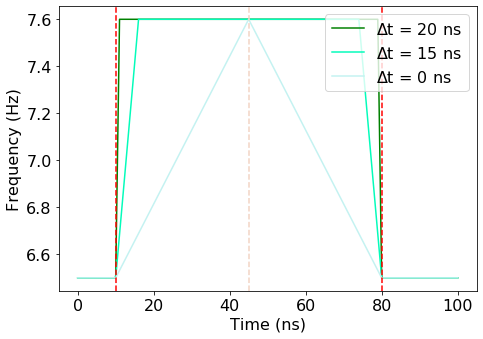

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

t_pulse1 = [t_pulse[0], t_pulse[1]+5, t_pulse[2]-5, t_pulse[3]]
t_pulse2 = [t_pulse[0], (t_pulse[3]-t_pulse[0])/2+t_pulse[0], (t_pulse[3]-t_pulse[0])/2+t_pulse[0], t_pulse[3]]
        
ax.plot(times, [rampPulseGen(t_pulse, w_q1, w_top, t) for t in times], 'g', label=r"$\Delta$t = 20 ns")
ax.plot(times, [rampPulseGen(t_pulse1, w_q1, w_top, t) for t in times], '#03fcba', label=r"$\Delta$t = 15 ns")
ax.plot(times, [rampPulseGen(t_pulse2, w_q1, w_top, t) for t in times], '#c4f2f1', label=r"$\Delta$t = 0 ns")

ax.axvline(x=t_pulse[0], color='r', linestyle='--')
ax.axvline(x=t_pulse[3], color='r', linestyle='--')
ax.axvline(x=t_pulse2[2], color='#f2d4c4', linestyle='--')

ax.set_xlabel('Time (ns)')
ax.set_ylabel('Frequency (Hz)')
ax.legend(loc="upper right")
fig.tight_layout()

In [115]:
opts = Odeoptions(max_step=0.0005, nsteps=50000)

# time dependent Hamiltonian
H_t = [H0 , [Hq1, wq1_t]]

# Evolving the system
res = mesolve(H_t, psi0, times, [], [], options=opts)

### 4.2 Plotting the results (with + without thermal losses)

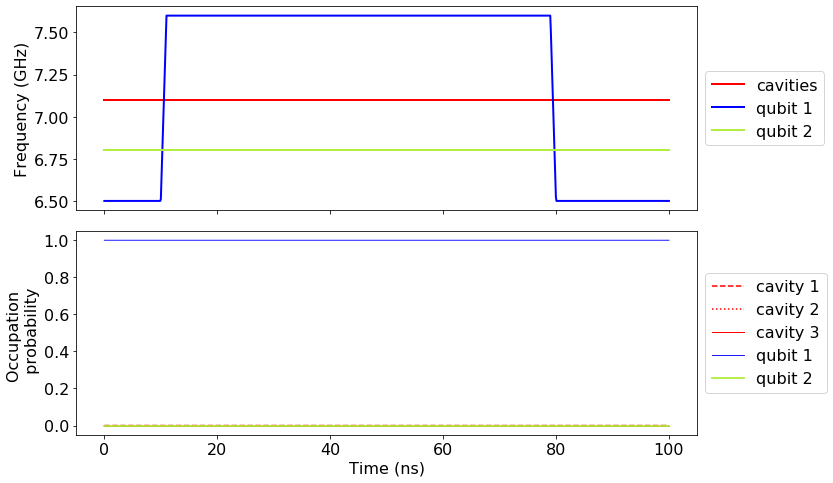

In [116]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,7))

axes[0].plot(times, np.array(list(map(wf_t, times))), 'r-', linewidth=2, label="cavities")
axes[0].plot(times, np.array(list(map(wq1_t, times))), 'b', linewidth=2, label="qubit 1")
axes[0].plot(times, np.array(list(map(wq2_t, times))), '#b0ed3e', linewidth=2, label="qubit 2")
axes[0].set_ylabel("Frequency (GHz)", fontsize=16)
axes[0].legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))

#axes[1].plot(times, np.real(expect(numOp(a1)+numOp(a2)+numOp(a3)+n1+n2, res.states)), 'k--', linewidth=1.5, label="Total Probability")
axes[1].plot(times, np.real(expect(numOp(a1), res.states)), 'r--', linewidth=1.5, label="cavity 1")
axes[1].plot(times, np.real(expect(numOp(a2), res.states)), 'r:', linewidth=1.5, label="cavity 2")
axes[1].plot(times, np.real(expect(numOp(a3), res.states)), 'r', linewidth=1, label="cavity 3")
axes[1].plot(times, np.real(expect(n1, res.states)), 'b', linewidth=0.9, label="qubit 1")
axes[1].plot(times, np.real(expect(n2, res.states)), '#b0ed3e', linewidth=1.8, label="qubit 2")
axes[1].set_xlabel("Time (ns)")
axes[1].set_ylabel("Occupation \n probability")
axes[1].legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))


fig.tight_layout()

In [91]:
def showProgress(idx, n):
    """
    Function prints the progress bar for a running function
    @param idx :: iterating index
    @param n :: total number of iterating variables/ total length
    """
    j = (idx+1)/n
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
    sys.stdout.flush()
    sleep(0.25)
    
def evaluateHam(ramp_vals, no_loss, t_eval, no_ramps):
    """
    Function evaluates the Hamiltonian for a range of different ramp pulses
    Input:
        @param ramp_vals :: np array containing the width of the ramp pulse (t2-t1)
        @param no_loss :: (bool) if including thermal losses -> False (else, True)
        @param t_eval :: (int) index of the time array where the pulse ends
        @param no_ramps :: number of ramps sent into the Hamiltonian
    Return:
        @param ramp_dt_array:: np array containing the exp. vals for each input pulse at t_eval
    """
    exp_vals = []
    ramp_dt_array = []
    for i in range(no_ramps):
        t_pulse = ramp_vals[i][:]        
        
        # time dependent Hamiltonian
        H_t = [H0, [Hq1, wq1_t]]

        # Evolving the system with/without thermal losses
        if no_loss == True:         
            output = mesolve(H_t, psi0, times, [], [])
        else:
            output = mesolve(H_t, psi0, times, c_ops, [])
    
        exp_vals = np.real(expect(n1, output.states))
        ramp_dt_array.append(exp_vals[t_eval])
        
        # progress bar
        showProgress(i, no_ramps)
    return ramp_dt_array

def findIndex(times, lower_lmt, upper_lmt):
    """
    Function finds the time at which the pulse ends
    @param times:: np array containing all the times
    @param lower_lmt :: lower limit of the range in which the pulse ends
    @param upper_lmt :: upper limit of the range in which the pulse ends
    Returns:
    @param idx[0] :: index value of the time closest to where the pulse ends
    """
    idx = []
    for j, t in enumerate(times):
        if t>=lower_lmt and t<=upper_lmt:
            idx.append(j)    
            return idx[0]

In [92]:
# find the index of the last point of the ramp
i = findIndex(times, t_pulse[3], t_pulse[3]+1)

# generating a range of pulse with varying ramp times
rampList = np.linspace((t_pulse[3]-t_pulse[0])/2-t_pulse[1], t_pulse[0], no_ramps)

# generates the expectation va
ramp_vals = np.empty((0, 4))
for dt in rampList:
    t_new = [t_pulse[0], t_pulse[1]+dt, t_pulse[2]-dt, t_pulse[3]]
    ramp_vals = np.append(ramp_vals, [t_new], axis=0)    

# evaluated at the end point of the pulse, without thermal losses
ramp_dt_array = evaluateHam(ramp_vals, True, i, no_ramps)

# evaluated at the end point of the pulse, with thermal losses
ramp_dt_array2 = evaluateHam(ramp_vals, False, i, no_ramps)

[====================] 100%

## 5. Results

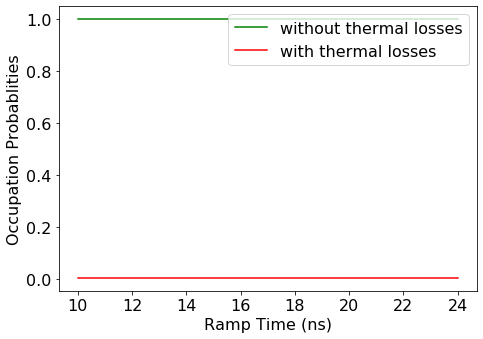

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
       
ax.plot(rampList, ramp_dt_array, 'g', label="without thermal losses")
ax.plot(rampList, ramp_dt_array2, 'r', label="with thermal losses")
ax.set_xlabel('Ramp Time (ns)')
ax.set_ylabel('Occupation Probablities')
ax.legend(loc="upper right")
fig.tight_layout()

In [94]:
# extract the final state from the result of the simulation
rho_final = res.states[-1]

# trace out the resonator mode and print the two-qubit density matrix
rho_qubits = ptrace(rho_final, [1,2])
rho_qubits

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[9.99995376e-01+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 2.74725132e-06+0.00000000e+00j
  8.36021276e-08+2.26888552e-06j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 8.36021276e-08-2.26888552e-06j
  1.87635940e-06+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]]

In [95]:
# compare to the ideal result of the sqrtiswap gate (plus phase correction) for the current initial state
rho_qubits_ideal = ket2dm(tensor(phasegate(0), phasegate(-pi/2)) * sqrtiswap() * tensor(basis(2,1), basis(2,0)))
rho_qubits_ideal

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.  0. ]]

### 5.2 Fidelity and Concurrence

In [96]:
fidelity(rho_qubits, rho_qubits_ideal)

0.0015477104112999972

In [97]:
concurrence(rho_qubits)

4.456464269326041e-06